In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [50]:
import sys
sys.path.append('../../src')
import numpy as np
import pandas as pd
import spaceoracle
import anndata
import scanpy as sc
from spaceoracle.models.probabilistic_estimators import ProbabilisticPixelModulators
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [5]:
data_ref = pd.read_csv('/Users/koush/Downloads/submit/case 1/data/simulate_data_2021_11_19_16_01_proj.csv')

In [6]:
spatial_dim = 64

def get_beta(row, col, row_ext, col_ext):
    
    beta0 = 1 + np.sin((1 / row_ext / col_ext * 4) * np.pi * (row_ext / 2 - row) * (col_ext / 2 - col)) + np.random.normal() / 8
    beta1 = 1 + np.abs(np.cos((1 / row_ext) * np.pi * row)) + np.sin((1 / col_ext) * np.pi * col) + np.random.normal() / 7
    beta2 = 1 + (1 / (4 * (np.power(col_ext / 2, 2) * 0.5) * (np.power(row_ext / 2, 2) * 0.5))) * (np.square(col_ext / 2) + np.square(col_ext / 2 - col)) * (np.square(row_ext / 2) - np.square(row_ext / 2 - row)) + np.random.normal() / 6
    beta3 = 1 + np.cos((1 / row_ext / col_ext * 2) * np.pi * row * col) + np.random.normal() / 5
    beta4 = 1 + np.sin((1 / row_ext) * np.pi * row) * np.cos((1 / col_ext) * np.pi * col) + np.random.normal() / 4
    beta5 = 1 + np.exp(-((row - row_ext/2)**2 + (col - col_ext/2)**2) / (row_ext * col_ext / 10)) + np.random.normal() / 3

    return beta0, beta1, beta2, beta3, beta4, beta5


row_range = spatial_dim
col_range = spatial_dim

beta0 = []
beta1 = []
beta2 = []
beta3 = []
beta4 = []
beta5 = []

for row_i in range(row_range):
    beta0_ = []
    beta1_ = []
    beta2_ = []
    beta3_ = []
    beta4_ = []
    beta5_ = []
    for col_i in range(col_range):
        beta0_i, beta1_i, beta2_i, beta3_i, beta4_i, beta5_i = get_beta(row_i, col_i, row_range, col_range)
        beta0_.append(beta0_i)
        beta1_.append(beta1_i)
        beta2_.append(beta2_i)
        beta3_.append(beta3_i)
        beta4_.append(beta4_i)
        beta5_.append(beta5_i)
    beta0.append(beta5_)
    beta1.append(beta1_)
    beta2.append(beta2_)
    beta3.append(beta3_)
    beta4.append(beta4_)
    beta5.append(beta0_)

beta0 = np.array(beta0, dtype=np.float64)
beta1 = np.array(beta1, dtype=np.float64)
beta2 = np.array(beta2, dtype=np.float64)
beta3 = np.array(beta3, dtype=np.float64)
beta4 = np.array(beta4, dtype=np.float64)
beta5 = np.array(beta5, dtype=np.float64)

In [155]:
data_ref['x3'] = np.random.rand(64, 64).flatten()
data_ref['x4'] = np.random.rand(64, 64).flatten()
data_ref['beta3'] = beta3.flatten()
data_ref['beta4'] = beta5.flatten()
data_ref['beta5'] = beta4.flatten()

data_ref['x3_received'] = ProbabilisticPixelModulators.received_ligands(
    data_ref[['proj_x', 'proj_y']].to_numpy(), 
    data_ref[['x3']], 
    radius=15000
)

data_ref['x3$x4'] = data_ref['x3_received']*data_ref['x4']
data_ref['y2'] = data_ref['beta4'] + data_ref['beta5']*data_ref['x1'] + data_ref['beta3']*data_ref['x3$x4']

100%|██████████| 1/1 [00:00<00:00,  6.76it/s]


In [156]:
adata = anndata.AnnData(
    X=data_ref[['x1', 'x2', 'x3', 'x4', 'x3_received', 'x3$x4','y', 'y2']],
    obs=data_ref[['id', 'row', 'col', 'latitude', 'longitude', 'proj_x', 'proj_y']],
    obsm={'spatial': data_ref[['proj_x', 'proj_y']].to_numpy()}
)

adata.obs['rctd_cluster'] = 0
adata.layers['imputed_count'] = adata.X
adata

AnnData object with n_obs × n_vars = 4096 × 8
    obs: 'id', 'row', 'col', 'latitude', 'longitude', 'proj_x', 'proj_y', 'rctd_cluster'
    obsm: 'spatial'
    layers: 'imputed_count'

In [157]:
adata.to_df()

,x1,x2,x3,x4,x3_received,x3$x4,y,y2
0,0.391720,0.566888,0.020456,0.957930,0.001212,0.001161,2.555933,1.433555
1,0.479254,0.183225,0.620775,0.503231,0.001520,0.000765,2.164192,1.720761
2,0.089783,0.308117,0.841273,0.217694,0.001727,0.000376,1.578343,1.293095
3,0.255784,0.107331,0.129506,0.066915,0.001825,0.000122,1.986638,1.437123
4,0.887085,0.555066,0.045233,0.286507,0.001846,0.000529,3.845633,2.069614
...,...,...,...,...,...,...,...,...
4091,0.542107,0.723439,0.587625,0.241051,0.001592,0.000384,3.740529,2.203154
4092,0.480357,0.827767,0.196673,0.719177,0.001519,0.001092,3.452458,2.030268
4093,0.808941,0.177852,0.627692,0.127917,0.001402,0.000179,3.318602,2.613562
4094,0.213466,0.334173,0.801175,0.906118,0.001209,0.001095,2.373481,1.404029


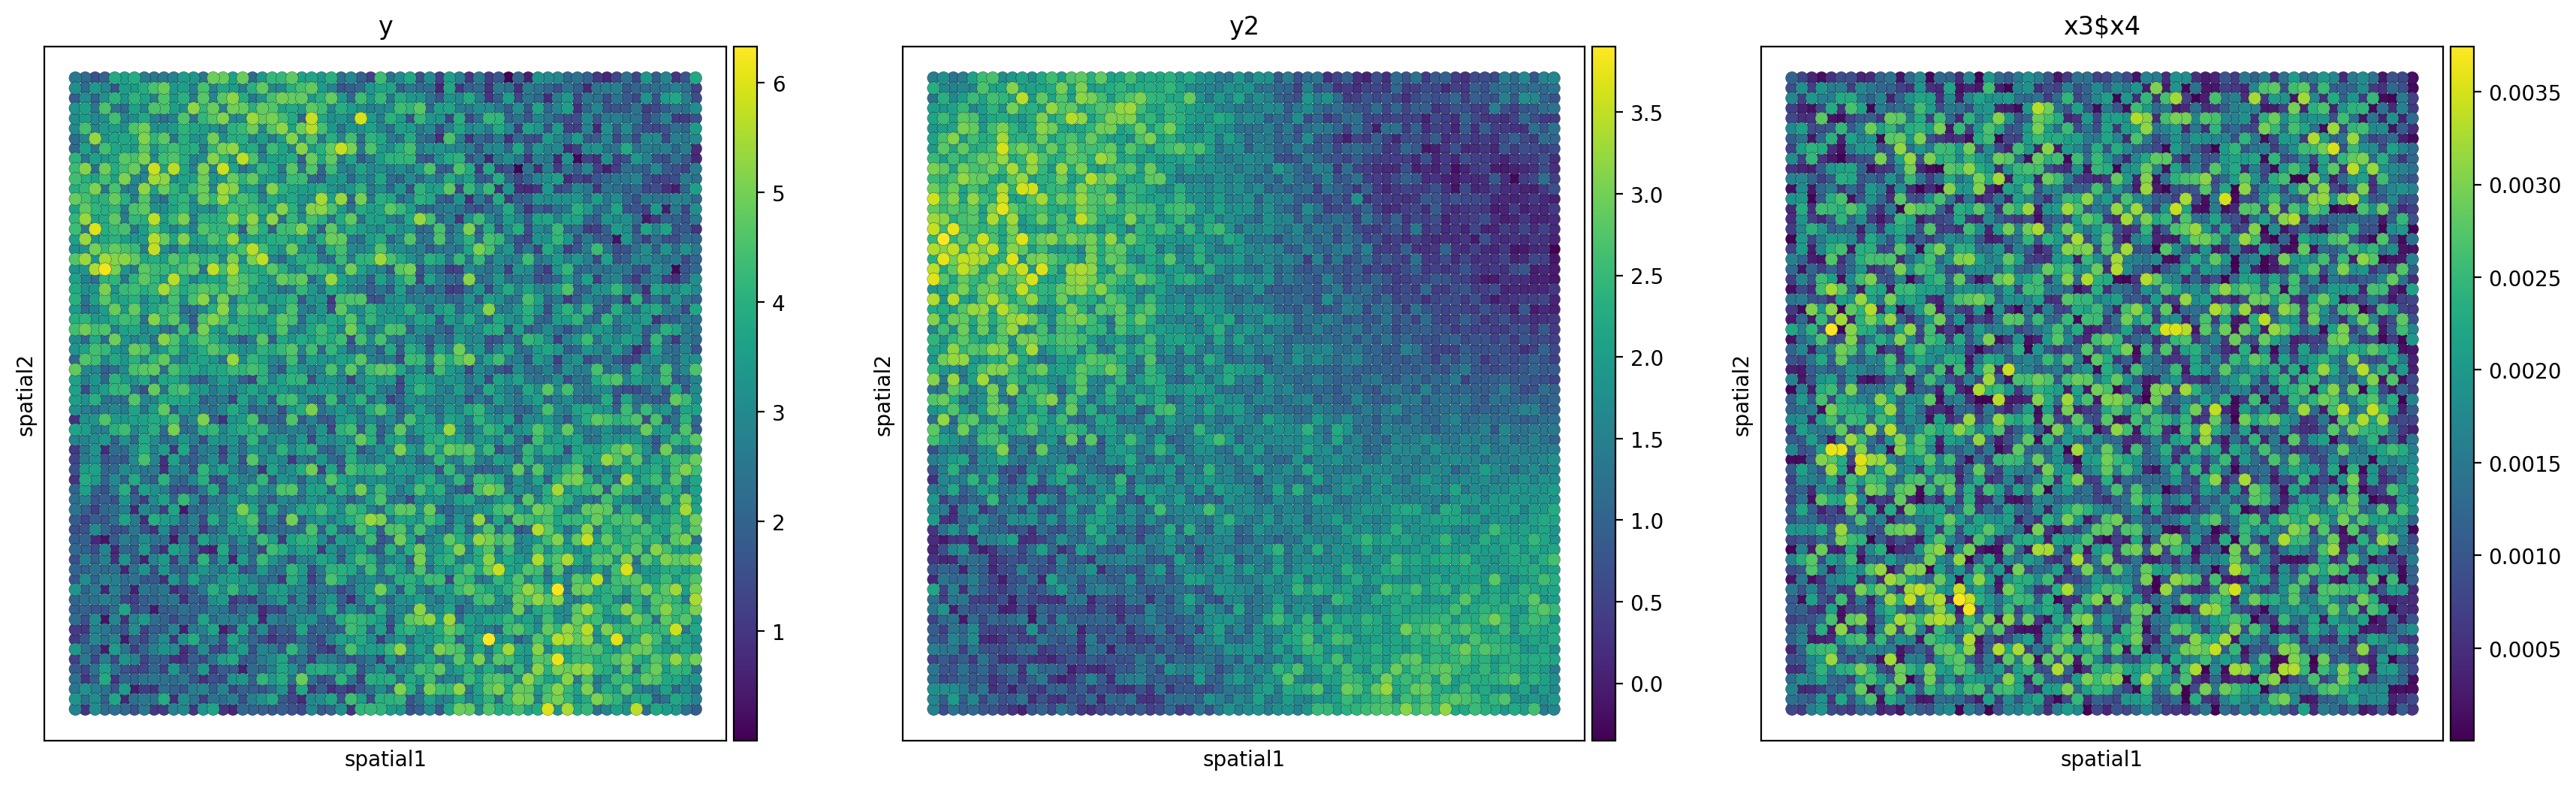

In [159]:
plt.rcParams['figure.figsize'] = [6, 6]
sc.pl.embedding(adata, basis='spatial', color=['y', 'y2', 'x3$x4'], 
    s=150, linewidth=0.1, edgecolor='black', layer='imputed_count')

In [160]:
spaceoracle.SpaceOracle.imbue_adata_with_space(
    adata,
    spatial_dim=64,
    method='fast',
    in_place=True,
)

🌍️ Generating spatial 64x64 maps...*


In [161]:
adata

AnnData object with n_obs × n_vars = 4096 × 8
    obs: 'id', 'row', 'col', 'latitude', 'longitude', 'proj_x', 'proj_y', 'rctd_cluster'
    obsm: 'spatial', 'spatial_maps'
    layers: 'imputed_count'

In [162]:
adata.to_df()

,x1,x2,x3,x4,x3_received,x3$x4,y,y2
0,0.391720,0.566888,0.020456,0.957930,0.001212,0.001161,2.555933,1.433555
1,0.479254,0.183225,0.620775,0.503231,0.001520,0.000765,2.164192,1.720761
2,0.089783,0.308117,0.841273,0.217694,0.001727,0.000376,1.578343,1.293095
3,0.255784,0.107331,0.129506,0.066915,0.001825,0.000122,1.986638,1.437123
4,0.887085,0.555066,0.045233,0.286507,0.001846,0.000529,3.845633,2.069614
...,...,...,...,...,...,...,...,...
4091,0.542107,0.723439,0.587625,0.241051,0.001592,0.000384,3.740529,2.203154
4092,0.480357,0.827767,0.196673,0.719177,0.001519,0.001092,3.452458,2.030268
4093,0.808941,0.177852,0.627692,0.127917,0.001402,0.000179,3.318602,2.613562
4094,0.213466,0.334173,0.801175,0.906118,0.001209,0.001095,2.373481,1.404029


In [211]:
x_train = adata.to_df()[['x1', 'x3$x4']].values
y_train = adata.to_df()[['y2']].values

In [212]:
x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train)

In [213]:
from pysal.model.spreg import OLS

In [214]:
ols = OLS(y_train, x_train_scaled, name_y = 'y', name_x = ['x1', 'x3$x4'])
beta_ols = ols.betas
beta_ols

array([[1.51994866e+00],
       [3.09068405e-01],
       [1.11644816e-03]])

In [215]:
dis_train = adata.obsm['spatial_maps'].reshape(-1, 64*64)

In [216]:
dis_scaler = StandardScaler()

dis_train_scaled = dis_scaler.fit_transform(dis_train)

In [217]:
dis_train_scaled.shape

(4096, 4096)

In [218]:
def reshape_dis(dis_to_reshape):
    dis_reshaped = []
    for i in range(dis_to_reshape.shape[0]):
        dis_ = np.expand_dims(dis_to_reshape[i].reshape(64, 64), axis=2)
        dis_reshaped.append(dis_)
    return np.array(dis_reshaped)

In [219]:
dis_train_scaled = reshape_dis(dis_train_scaled)
print('dis_train_scaled shape:', dis_train_scaled.shape)

dis_train_scaled shape: (4096, 64, 64, 1)


In [220]:
import torch.nn as nn
import random
import torch
from torch.nn.utils.parametrizations import weight_norm

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

In [221]:
beta_ols

array([[1.51994866e+00],
       [3.09068405e-01],
       [1.11644816e-03]])

In [222]:
class SimpleCNN(nn.Module):
    def __init__(self, nbetas, spatial_dim=64,in_channels=1, init=0.1):
        set_seed(42)
        super().__init__()
        self.dim = nbetas
        # self.betas = torch.tensor(betas.astype(np.float32)).to(device)
        
        self.conv_layers = nn.Sequential(
            weight_norm(nn.Conv2d(in_channels, 32, kernel_size=3, padding='same')),
            nn.PReLU(init=init),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            weight_norm(nn.Conv2d(32, 64, kernel_size=3, padding='same')),
            nn.PReLU(init=init),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            weight_norm(nn.Conv2d(64, 256, kernel_size=3, padding='same')),
            nn.PReLU(init=init),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(256, 128),
            nn.PReLU(init=init),
            
            nn.Linear(128, 64),
            nn.PReLU(init=init),
            
            nn.Linear(64, 16),
            nn.PReLU(init=init),
            nn.Dropout(0.2),
            nn.Linear(16, self.dim)
        )

    def forward(self, spatial_map):
        spatial_features = self.conv_layers(spatial_map)
        betas = self.fc_layers(spatial_features)
        return betas
    
    def predict_y(self, spatial_map, inputs_x):
        betas = self.forward(spatial_map)
        w0 = betas[:, 0]
        w1 = betas[:, 1]
        w2 = betas[:, 2]

        y_pred = w0*beta_ols[0][0] + w1*beta_ols[1][0]*inputs_x[:, 0] + w2*beta_ols[2][0]*inputs_x[:, 1]
        
        return y_pred

In [223]:
import sys
sys.path.append('../../src')
from spaceoracle.models.pixel_attention import ConditionalConv2D


class NicheAttentionNetwork(nn.Module):
     
    def __init__(self, n_regulators, in_channels, spatial_dim):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = in_channels
        self.spatial_dim = spatial_dim
        self.dim = n_regulators+1
        # self.conditional_conv = ConditionalConv2D(self.in_channels, self.in_channels, 1)
        self.conditional_conv = nn.Conv2d(self.in_channels, self.in_channels, 1)

        self.sigmoid = nn.Sigmoid()

        self.conv_layers = nn.Sequential(
            weight_norm(nn.Conv2d(in_channels, 32, kernel_size=3, padding='same')),
            nn.PReLU(init=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            weight_norm(nn.Conv2d(32, 64, kernel_size=3, padding='same')),
            nn.PReLU(init=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            weight_norm(nn.Conv2d(64, 128, kernel_size=3, padding='same')),
            nn.PReLU(init=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )

        self.cluster_emb = nn.Embedding(self.in_channels, 128)

        self.mlp = nn.Sequential(
            nn.Linear(128, 64),
            nn.PReLU(init=0.1),
            nn.Linear(64, self.dim)
        )

        self.alpha = nn.Parameter(torch.tensor(1.0), requires_grad=True)

        self.output_activation = nn.Tanh()


    def forward(self, spatial_maps, cluster_info):
        # att = self.sigmoid(self.conditional_conv(spatial_maps, cluster_info))
        att = self.sigmoid(self.conditional_conv(spatial_maps))
        out = att * spatial_maps
        out = self.conv_layers(out)
        emb = self.cluster_emb(cluster_info) * self.alpha
        out = out + emb 
        betas = self.mlp(out)
        return betas
    
    def predict_y(self, spatial_map, inputs_x, cluster_info):
        betas = self.forward(spatial_map, cluster_info)
        w0 = betas[:, 0]
        w1 = betas[:, 1]
        w2 = betas[:, 2]

        y_pred = w0*beta_ols[0][0] + w1*beta_ols[1][0]*inputs_x[:, 0] + w2*beta_ols[2][0]*inputs_x[:, 1]
        
        return y_pred

In [224]:
# model = SimpleCNN(nbetas=3, spatial_dim=64, in_channels=1, init=0.1)

In [238]:
train_idx = np.random.choice(adata.obs.index, 2048).astype(np.int32)

In [239]:
train_idx

array([2871,  797, 3313, ..., 2137, 3416,  349], dtype=int32)

In [240]:
dis_train_scaled[train_idx].shape

(2048, 64, 64, 1)

In [241]:
import enlighten

In [242]:
# Define loss function and optimizer
criterion = nn.MSELoss()
model = NicheAttentionNetwork(3, in_channels=1, spatial_dim=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1000

manager = enlighten.get_manager()
pbar = manager.counter(
    total=num_epochs, 
    desc='Epochs', 
    unit='epoch'
)

losses = []
for epoch in range(num_epochs):
    model.train()
    # Convert numpy arrays to PyTorch tensors
    spatial_map = torch.from_numpy(dis_train_scaled[train_idx]).permute(0, 3, 1, 2).float()
    inputs_x = torch.from_numpy(x_train[train_idx]).float()
    cluster_info = torch.zeros(spatial_map.shape[0]).long()
    y_true = torch.from_numpy(y_train[train_idx]).float()

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    y_pred = model.predict_y(spatial_map, inputs_x, cluster_info)

    # Compute loss
    loss = criterion(y_pred.squeeze(), y_true.squeeze())
    losses.append(loss.item())

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    model.eval()
    pbar.update(1)
    pbar.desc = f'Epoch [{epoch}/{num_epochs}], Loss: {np.mean(losses):.4f}'
    
    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {np.mean(losses):.4f}')
        # y_true, beta0_pred, beta1_pred, beta2_pred = gather_predictions(model)

        # fig, ax = plt.subplots(1, 3, figsize=(20, 10))
        # ax = ax.flatten()
        # cmap = 'RdYlBu_r'
        # ax[0].matshow(beta0_pred, cmap=cmap)
        # ax[1].matshow(beta1_pred, cmap=cmap)
        # ax[2].matshow(beta2_pred, cmap=cmap)
        # plt.savefig(f'/tmp/sim/beta_pred_{epoch}.png', dpi=120)
        # plt.close(fig)  # Close the figure to prevent display

Epoch [0/1000], Loss: 1.8919
Epoch [100/1000], Loss: 0.5698
Epoch [200/1000], Loss: 0.3871
Epoch [300/1000], Loss: 0.2781
Epoch [400/1000], Loss: 0.2212
Epoch [500/1000], Loss: 0.1864
Epoch [600/1000], Loss: 0.1629
Epoch [700/1000], Loss: 0.1458
Epoch [800/1000], Loss: 0.1330
Epoch [900/1000], Loss: 0.1228


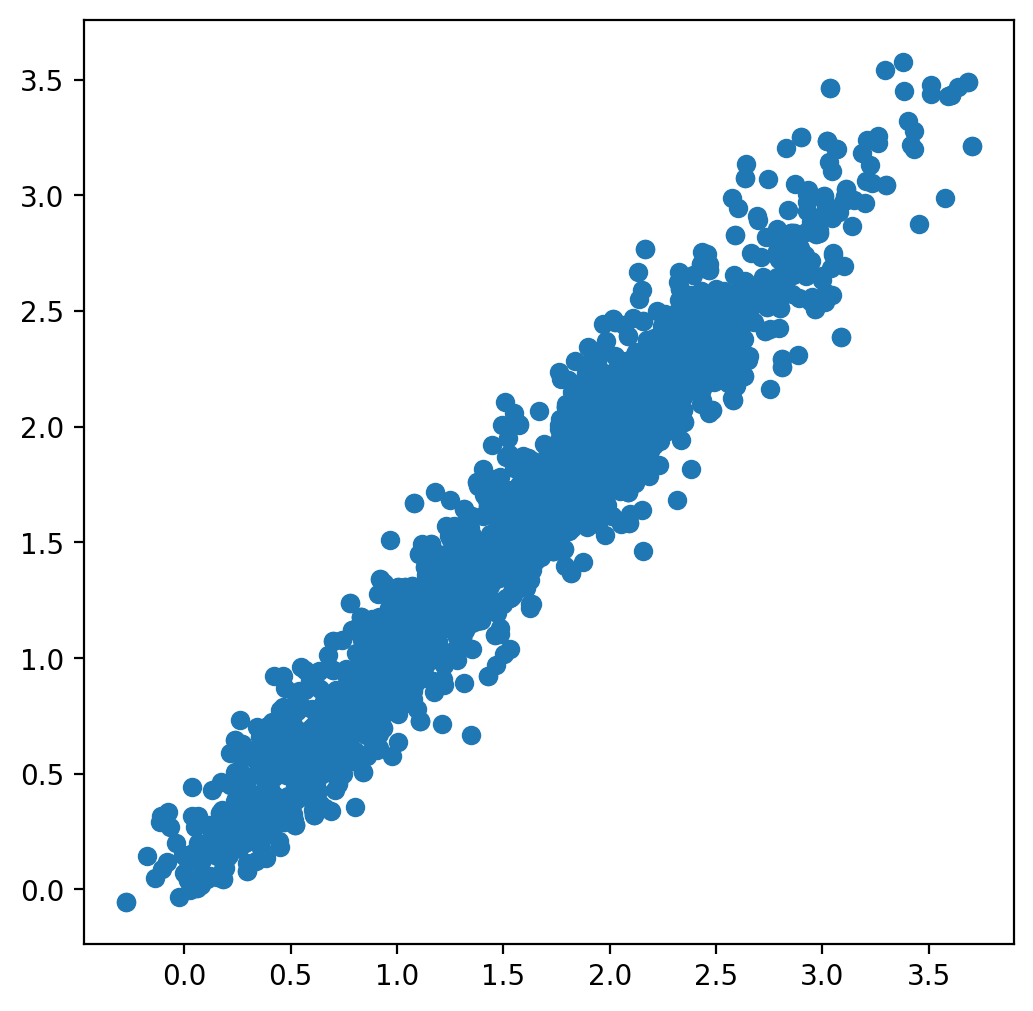

In [243]:
plt.scatter(y_true.detach().numpy(), y_pred.squeeze().detach().numpy())
plt.show()

In [244]:
model.eval();

In [245]:
with torch.no_grad():
    betas = model.forward(
        torch.from_numpy(dis_train_scaled).permute(0, 3, 1, 2).float(),
        torch.zeros(dis_train_scaled.shape[0]).long()
    )
print(betas)


tensor([[ 0.7874,  4.1693, -0.3984,  1.0890],
        [ 0.7737,  4.1520, -0.3501,  1.0858],
        [ 0.7802,  4.1388, -0.2956,  1.0787],
        ...,
        [ 1.1190,  2.1198, -0.5614,  0.6219],
        [ 1.1171,  2.1387, -0.6296,  0.6219],
        [ 1.1269,  2.1569, -0.7051,  0.6271]])


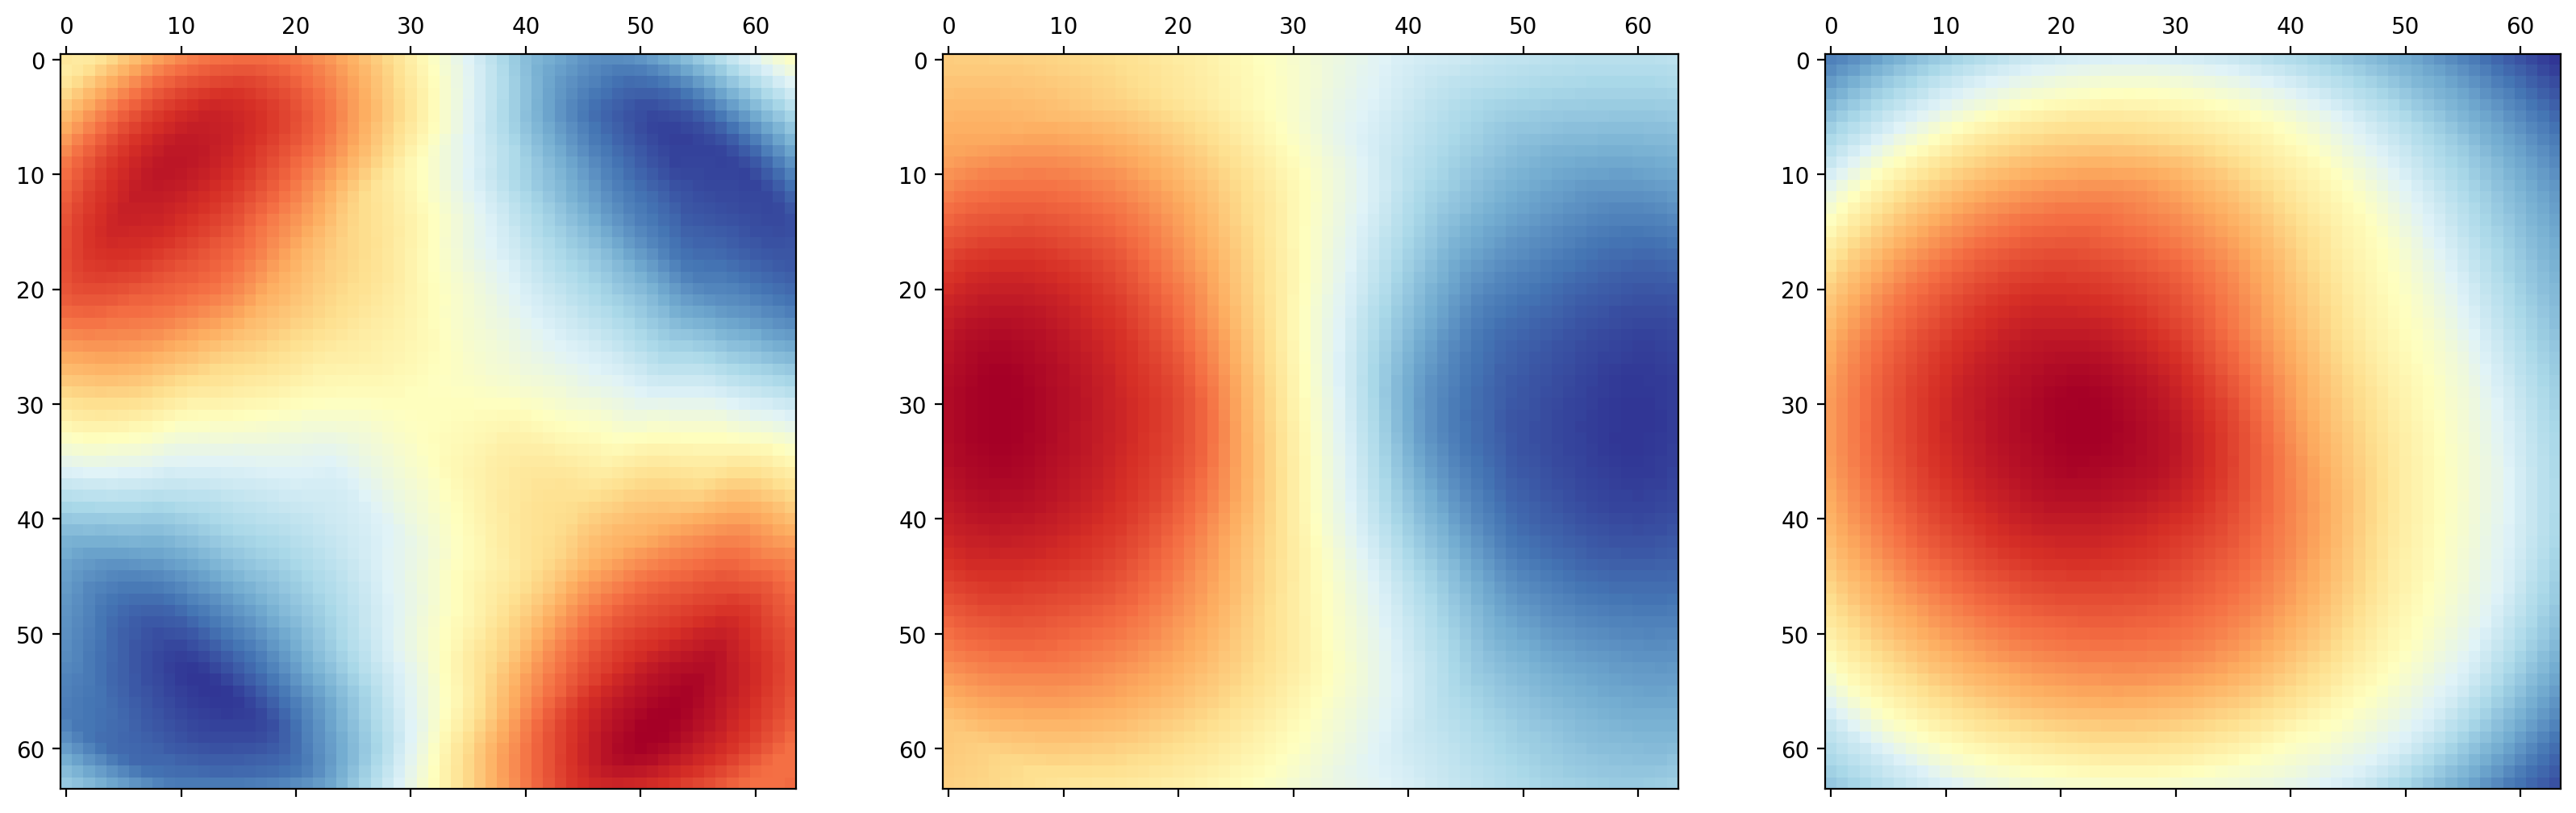

In [246]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax = ax.flatten()
cmap = 'RdYlBu_r'
ax[0].matshow(betas[:, 0].reshape(64, 64), cmap=cmap)
ax[1].matshow(betas[:, 1].reshape(64, 64), cmap=cmap)
ax[2].matshow(betas[:, 2].reshape(64, 64), cmap=cmap)
plt.show()

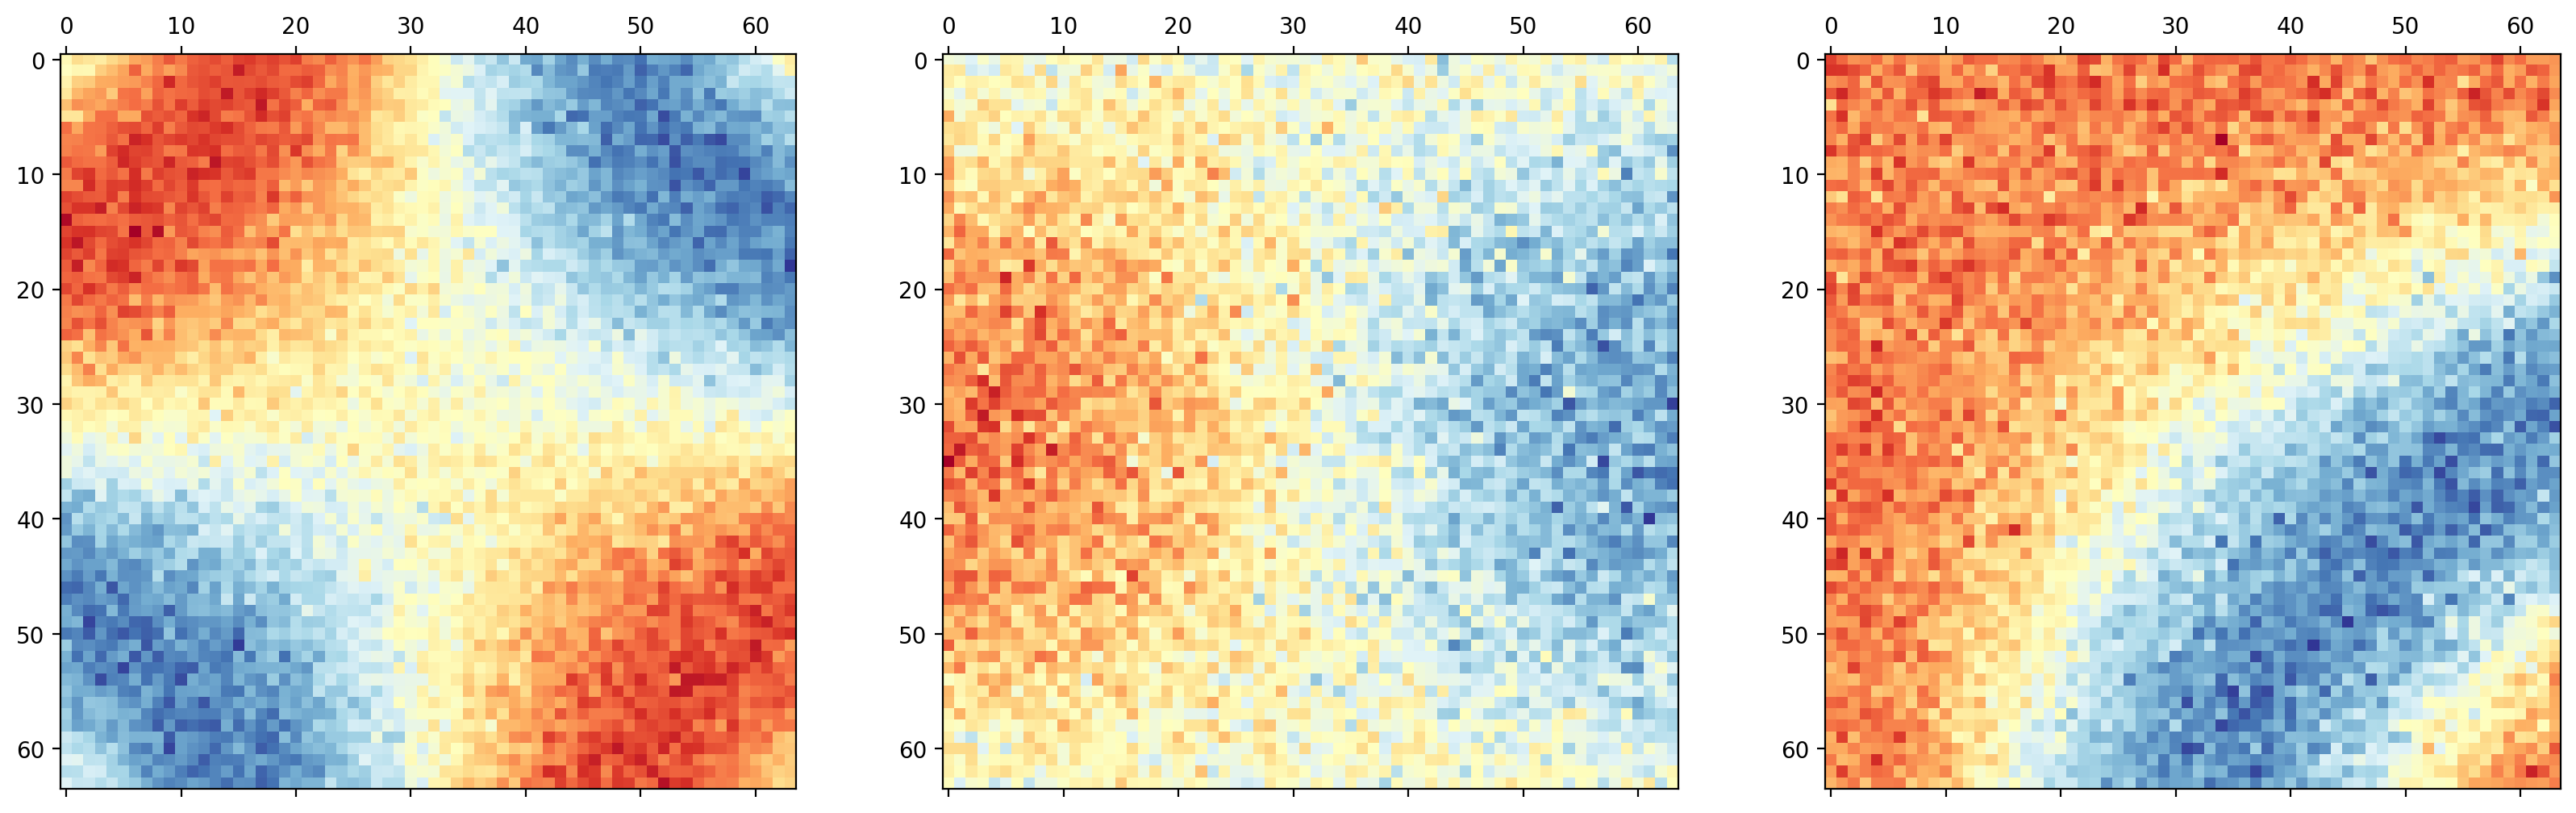

In [236]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax = ax.flatten()
cmap = 'RdYlBu_r'
ax[0].matshow(data_ref['beta4'].values.reshape(64, 64), cmap=cmap)
ax[1].matshow(data_ref['beta5'].values.reshape(64, 64), cmap=cmap)
ax[2].matshow(data_ref['beta3'].values.reshape(64, 64), cmap=cmap)
plt.show()

In [234]:
# data_ref['y2'] = data_ref['beta4'] + data_ref['beta5']*data_ref['x1'] + data_ref['beta3']*data_ref['x3$x4']


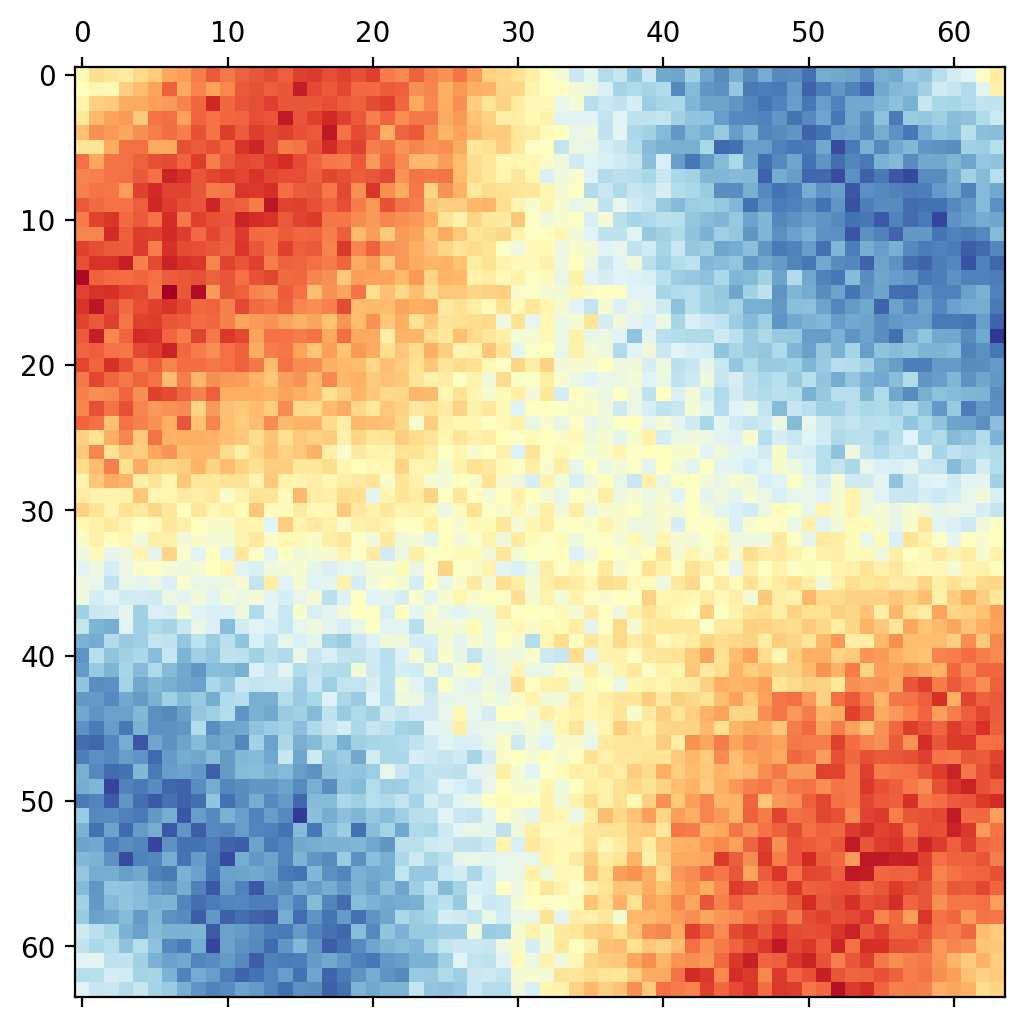

In [235]:
plt.matshow(data_ref['beta4'].values.reshape(64, 64), cmap=cmap)



In [118]:
data_ref.iloc[train_idx]

,id,row,col,latitude,longitude,beta0,beta1,beta2,x1,x2,y,proj_x,proj_y,x3,x4,beta3,beta4,beta5,x3_received,y2
3353,3353,52,25,36.674603,115.396825,0.572677,2.666337,1.286203,0.437384,0.696861,2.635195,12845915.84,4368324.846,0.148393,0.140660,0.540574,0.644409,1.622621,0.003571,0.000272
554,554,8,42,37.373016,115.666667,0.122728,2.658948,1.651412,0.041634,0.230109,0.613434,12875954.44,4465289.818,0.359495,0.218913,1.752233,0.466426,0.546563,0.002917,0.001119
1388,1388,21,44,37.166667,115.698413,0.429674,2.517120,1.915650,0.963215,0.520516,3.851328,12879488.39,4436547.279,0.215193,0.109410,1.381477,0.613072,0.561005,0.003167,0.000479
1341,1341,20,61,37.182540,115.968254,0.376367,1.614958,2.539966,0.169431,0.071464,0.831507,12909526.98,4438755.427,0.405001,0.367717,0.720624,0.045277,-0.092572,0.002949,0.000781
414,414,6,30,37.404762,115.476191,0.978301,3.028588,1.219020,0.928716,0.238820,4.082125,12854750.72,4469718.814,0.061920,0.337421,1.953039,1.090164,1.034800,0.003073,0.002025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2599,2599,40,39,36.865079,115.619048,1.237128,2.570164,1.873663,0.899097,0.331862,4.169753,12870653.51,4394680.905,0.418475,0.048383,-0.215164,1.193402,0.952765,0.003196,-0.000033
783,783,12,15,37.309524,115.238095,1.697090,2.647641,1.686052,0.858938,0.814967,5.345325,12828246.08,4456437.493,0.532529,0.356658,1.673080,1.879762,1.578218,0.002555,0.001525
1787,1787,27,59,37.071429,115.936508,0.662780,1.524646,2.625023,0.459944,0.868590,3.644100,12905993.03,4423308.198,0.777361,0.403889,0.092148,0.600838,-0.049724,0.003217,0.000120
3096,3096,48,24,36.738095,115.380952,0.662195,2.688590,1.729781,0.132273,0.969727,2.695238,12844148.87,4377102.865,0.648861,0.525645,0.770931,0.593757,1.404939,0.003604,0.001460


In [114]:
# import os
# import glob
# from PIL import Image
# import imageio

# # Path to the folder containing the images
# image_folder = '/tmp/sim/'

# # Get all png files in the folder, sorted by name
# image_files = sorted(glob.glob(os.path.join(image_folder, 'beta_pred_*.png')))

# # Read all images
# images = []
# for filename in image_files:
#     images.append(imageio.imread(filename))

# # Save as GIF
# output_file = '/tmp/sim/beta_predictions.gif'
# imageio.mimsave(output_file, images, duration=60)  # duration is the time between frames in seconds

# print(f"GIF created: {output_file}")


In [105]:
y_true, beta0_true, beta1_true, beta2_true, y_pred, beta0_pred, beta1_pred, beta2_pred = gather_predictions(model)

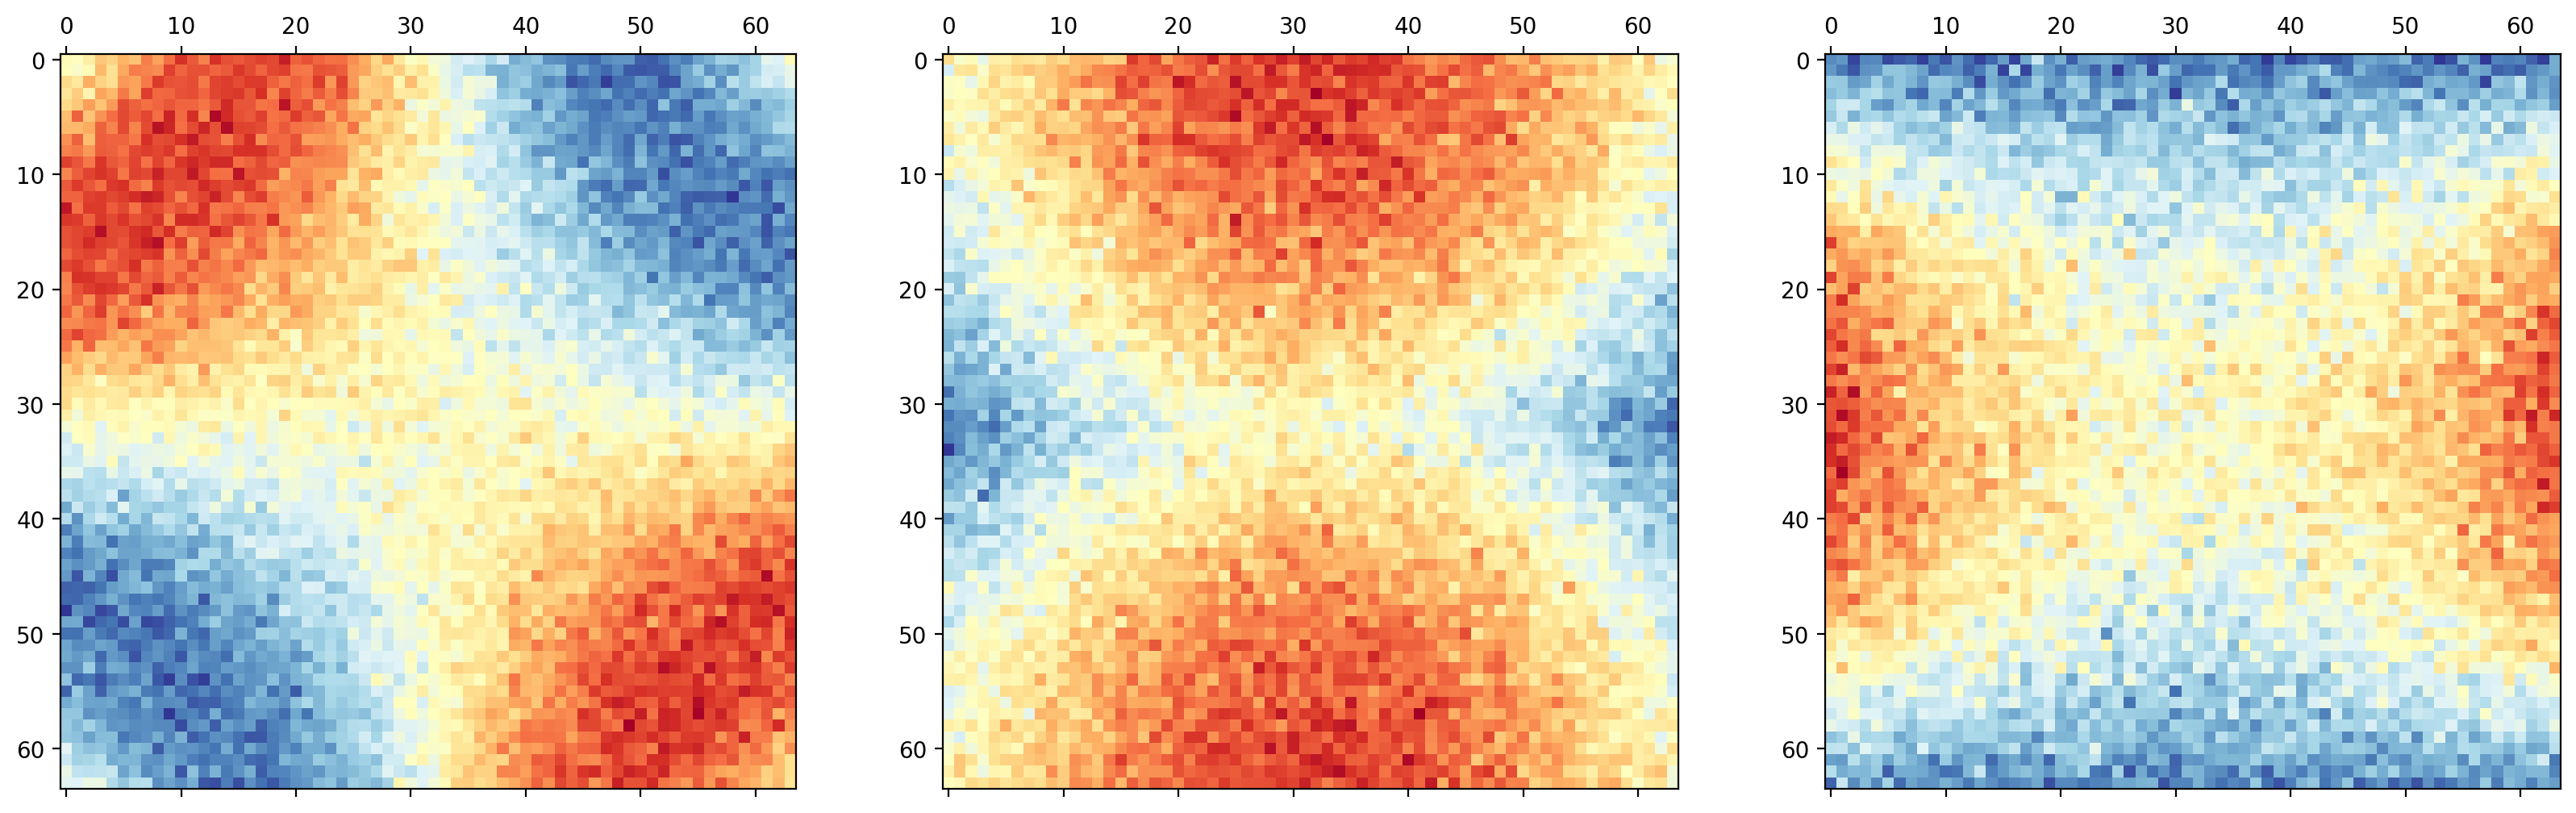

In [106]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax = ax.flatten()
cmap = 'RdYlBu_r'
ax[0].matshow(beta0_true, cmap=cmap)
ax[1].matshow(beta1_true, cmap=cmap)
ax[2].matshow(beta2_true, cmap=cmap)
plt.show()

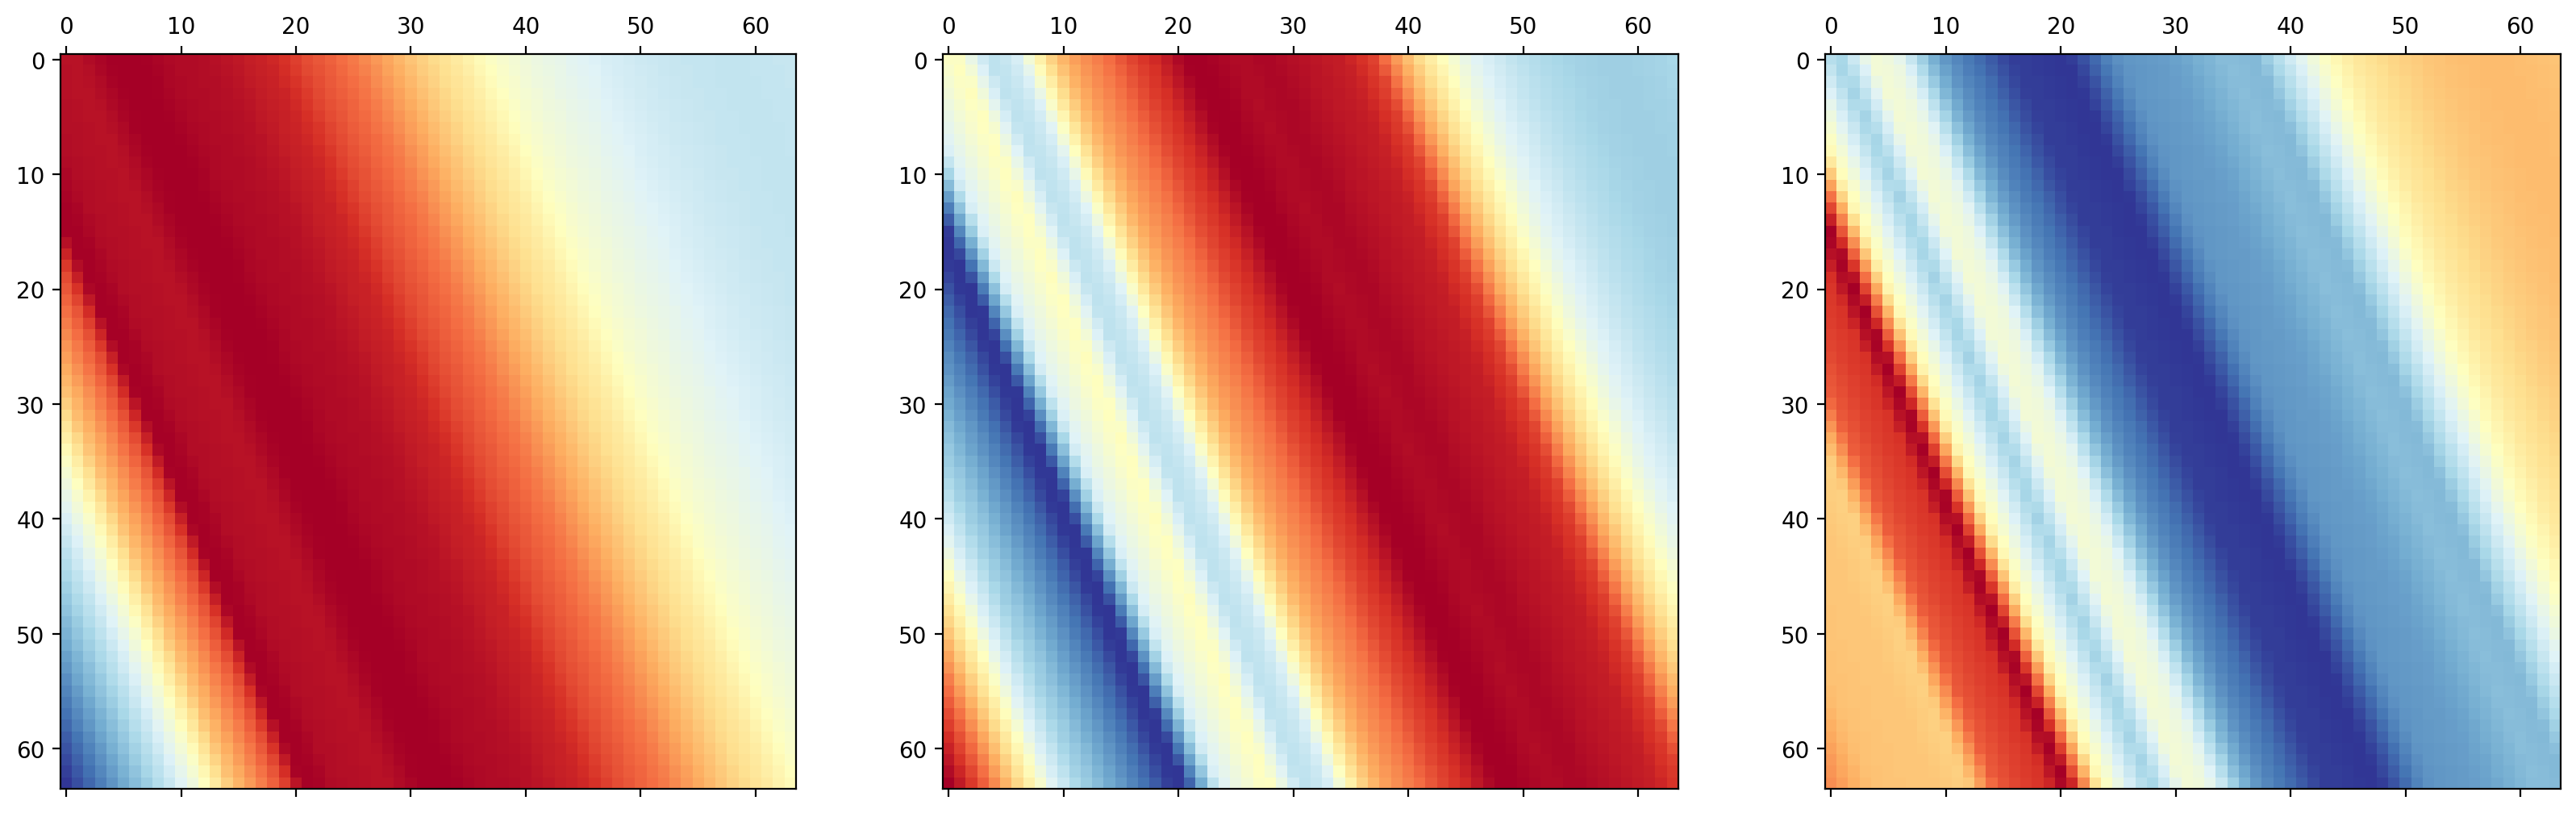

In [107]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax = ax.flatten()
cmap = 'RdYlBu_r'
ax[0].matshow(beta0_pred, cmap=cmap)
ax[1].matshow(beta1_pred, cmap=cmap)
ax[2].matshow(beta2_pred, cmap=cmap)
plt.show()

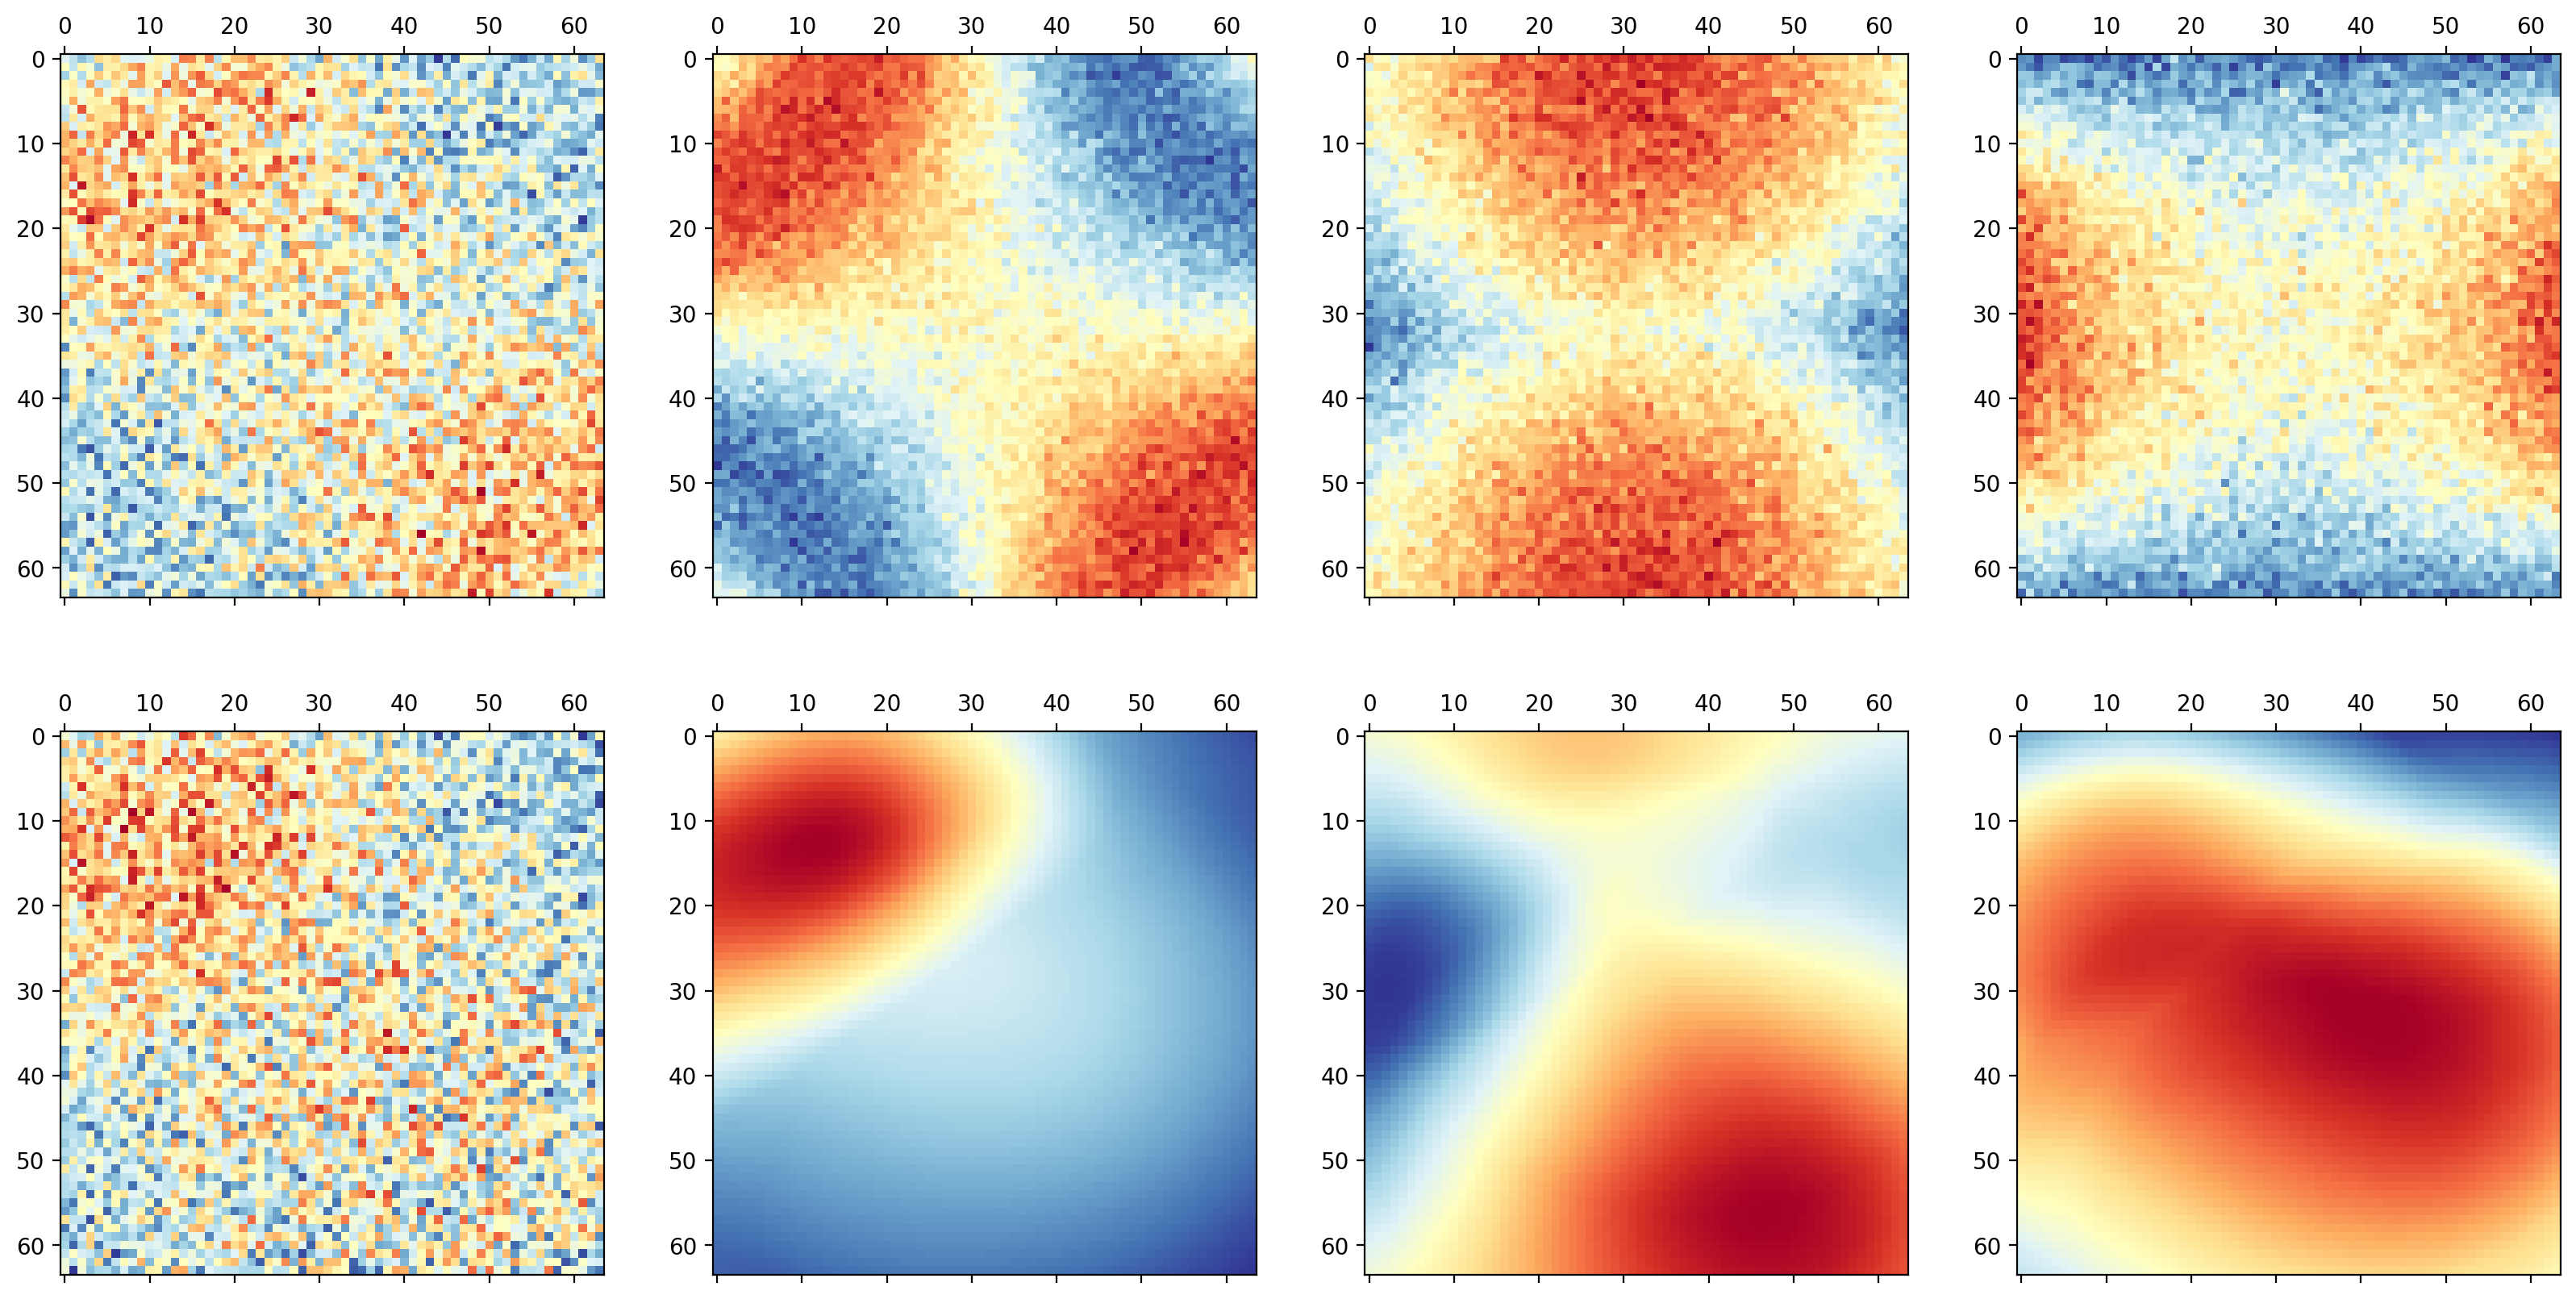

In [168]:
figure = plt.figure(figsize=(20, 10))
cmap = 'RdYlBu_r'
axes_y_true = figure.add_subplot(2, 4, 1)
axes_beta0_true = figure.add_subplot(2, 4, 2)
axes_beat1_true = figure.add_subplot(2, 4, 3)
axes_beta2_true = figure.add_subplot(2, 4, 4)
axes_y_pred = figure.add_subplot(2, 4, 5)
axes_beta0_pred = figure.add_subplot(2, 4, 6)
axes_beat1_pred = figure.add_subplot(2, 4, 7)
axes_beta2_pred = figure.add_subplot(2, 4, 8)

axes_y_true.matshow(y_true, cmap=cmap)
axes_beta0_true.matshow(beta0_true, cmap=cmap)
axes_beat1_true.matshow(beta1_true, cmap=cmap)
axes_beta2_true.matshow(beta2_true, cmap=cmap)
axes_y_pred.matshow(y_pred, cmap=cmap)
axes_beta0_pred.matshow(beta0_pred, cmap=cmap)
axes_beat1_pred.matshow(beta1_pred, cmap=cmap)
axes_beta2_pred.matshow(beta2_pred, cmap=cmap)

plt.show()